# Pulse Engine -FHIR Interface App

## Overview

The Pulse Engine -FHIR Interface App is a Jupyter Notebook application that leverages the Pulse Physiology Engine to simulate physiological scenarios and integrates with a Fast Healthcare Interoperability Resources (FHIR) server to manage the observations recorded during simulations.

Access Jupyter Notebook at http://127.0.0.1:8888/notebook
### Usage
- The FHIR server is configured at http://host.docker.internal:8180/fhir
- Run the notebook and enter the patient ID when prompted
- Use interactive buttons to simulate scenarios (e.g., airway obstruction)
- Results are logged and sent to the FHIR server in real-time
### FHIR Server Configuration
- The application uses http://host.docker.internal:8180/fhir to communicate with the FHIR server. This special hostname allows the notebook application to reach the FHIR server inside the Docker container's network
### Simulating Scenarios
- Run the application notebook within the Jupyter interface
- Enter the patient_id when prompted
- Use the interactive buttons to simulate different physiological scenarios
- Simulation results will be logged and sent to the FHIR server in real-time
- The results of the simulation displayed in graph in Heart rate vs Time and Respiratory Rate vs Time

#### Coniguration setup class

In [3]:
import configparser
class ConfigFile:
    def __init__(self):
        self.config = configparser.ConfigParser()
        self.config.read("config.ini")
    def get_FHIR_server_url(self):
        return self.config['FHIR']['server_url']
    def get_time_zone(self):
        return self.config['TIME_ZONE']['time_zone']

### UserInterface Component
##### This component is for handling control widgets, and display outputs.

In [4]:
import ipywidgets as widgets
from IPython.display import display, clear_output
class UserInterface:
    def __init__(self, simulation_core):
        self.simulation_core = simulation_core
        self.output = widgets.Output()
        self._create_widgets()
    
    # Create the widgets for the user interface, the buttons for obstructing and clearing the airway
    # and the output widget for displaying the patient's initial state of the patient and state after each action
    def _create_widgets(self):
        self.button_obstruct_airway = widgets.Button(description="Obstruct Airway for 20 sec")
        self.button_clear_airway = widgets.Button(description="Clear Airway for 20 sec")
        self.button_obstruct_airway.on_click(self._obstruct_airway)
        self.button_clear_airway.on_click(self._clear_airway)
        display(self.button_obstruct_airway, self.button_clear_airway, self.output)

    # Obstructs the airway for 20 seconds and displays the patient's state after the obstruction
    def _obstruct_airway(self, b):
        with self.output:
            clear_output()
            self.simulation_core.obstruct_airway()

    # Clears the airway for 20 seconds and displays the patient's state after the obstruction
    def _clear_airway(self, b):
        with self.output:
            clear_output()
            self.simulation_core.clear_airway()


### Simulation Core Component
##### This component is for handling the simulation core logic and initiating the PulseEngine and DataRequestManager.

In [5]:
from pulse.engine.PulseEngine import PulseEngine
from pulse.cdm.engine import SEDataRequest, SEDataRequestManager
from pulse.cdm.scalars import FrequencyUnit
from pulse.cdm.patient_actions import SEAirwayObstruction
from datetime import datetime

# SimulationCore class is responsible for initializing the PulseEngine, loading the initial state of the patient
class SimulationCore:
    def __init__(self, patient_id, data_management):
        self.patient_id = patient_id
        self.pulse = PulseEngine()
        self.data_management = data_management
        self.data_requests = [
            SEDataRequest.create_physiology_request("HeartRate", unit=FrequencyUnit.Per_min),
            SEDataRequest.create_physiology_request("RespirationRate", unit=FrequencyUnit.Per_min),
        ]
        self.data_req_mgr = SEDataRequestManager(self.data_requests)
        self.data_req_mgr.set_results_filename("./simulation_results/UseCase1.csv")
        if not self.pulse.serialize_from_file("./data/states/Soldier@0s.pbb", self.data_req_mgr):
            print("Unable to load initial state file")
        else:
            self.results = self.pulse.pull_data()
        self._advance_time_and_record(1)

    # Advances the time by 1 second and prints the patient's state after each action taken
    def _advance_time_and_record(self, seconds, action=None):
        if action:
            self.pulse.process_action(action)
        for second in range(1, seconds + 1):
            self.pulse.advance_time_s(1)
            self.results = self.pulse.pull_data()
        self.data_management.FHIR_data_mapper(self.results)
    
    # Obstructs the patient's airway for 20 seconds
    def obstruct_airway(self):
        airway_obstruction = SEAirwayObstruction()
        airway_obstruction.set_comment("Patient Airway is obstructed")
        airway_obstruction.get_severity().set_value(1)
        print("Obstructing patient airway...")
        self._advance_time_and_record(20, airway_obstruction)
    
    # Clears the patient's airway for 20 seconds
    def clear_airway(self):
        airway_clear = SEAirwayObstruction()
        airway_clear.set_comment("Patient Airway is cleared")
        airway_clear.get_severity().set_value(0)
        print("Clearing patient airway...")
        self._advance_time_and_record(20, airway_clear)


#### DataManagement Component
##### The component is for handling FHIR mapping and CSV file management.

In [6]:
import csv
import os
import logging
import requests
from datetime import datetime
import pytz

# DataManagement class is responsible for saving the patient's data to a CSV file and mapping the data to FHIR resources
class DataManagement:
    def __init__(self, patient_id, config_file):
        self.FHIR_SERVER_URL = config_file.get_FHIR_server_url()
        self.time_zone = config_file.get_time_zone()
        self.patient_id = patient_id
        self.csv_file_path = "./simulation_results/UseCase1.csv"
        os.makedirs(os.path.dirname(self.csv_file_path), exist_ok=True)

    def _get_result_from_csv(self, csv_file_path):
        last_line = None
        with open(csv_file_path, 'r') as file:
            reader = csv.reader(file)
            for line in reader:
                last_line = line
        return last_line

    # Maps the patient's data to FHIR resources and sends the observations to the FHIR server
    def FHIR_data_mapper(self, results):
        timezone = pytz.timezone(self.time_zone)
        timezone_now = datetime.now(timezone)
        read_vital = self._get_result_from_csv(self.csv_file_path)

        if not read_vital:
            print("No data available")
            return

        # Assuming the first row is headers
        if read_vital[1] == "HeartRate(1/min)" and read_vital[2] == "RespirationRate(1/min)":
            read_vital = [0, 82, 15 ]

        observations = [
            {"loinc_code": "8867-4", "display": "Heart Rate", "value": read_vital[1], "unit": "beats/minute"},
            {"loinc_code": "9279-1", "display": "Respiratory Rate", "value": read_vital[2], "unit": "breaths/minute"}
        ]

        for obs in observations:
            observation_data = {
                "resourceType": "Observation",
                "status": "final",
                "effectiveDateTime": timezone_now.isoformat(),
                "code": {
                    "coding": [{"system": "http://loinc.org", "code": obs['loinc_code'], "display": obs['display']}]
                },
                "subject": {"reference": f"Patient/{self.patient_id}"},
                "valueQuantity": {
                    "value": obs['value'],
                    "unit": obs['unit'],
                    "system": "http://unitsofmeasure.org"
                }
            }
            response = requests.post(f"{self.FHIR_SERVER_URL}/Observation", json=observation_data, headers={"Content-Type": "application/fhir+json"})
            if response.status_code == 201:
                print(f"{obs['display']} value: {obs['value']}")
            else:
                logging.error(f"Failed to add observation {obs['display']}, status code: {response.status_code}, reason: {response.text}")


##### Main Script
###### Finally, integrate these components in the main script:



In [7]:
patient_id = input("Enter the patient ID: ")
print(" Initial state of the patient:")
print("------------------------------:\n")
config_file = ConfigFile()
data_management = DataManagement(patient_id,config_file)
simulation_core = SimulationCore(patient_id, data_management)
ui = UserInterface(simulation_core)

Enter the patient ID:  1


 Initial state of the patient:
------------------------------:

Heart Rate value: 85.714286
Respiratory Rate value: 15.957447


Button(description='Obstruct Airway for 20 sec', style=ButtonStyle())

Button(description='Clear Airway for 20 sec', style=ButtonStyle())

Output()

### Using the UI provided in application play for couple of minutes, check the following graph to see the effect

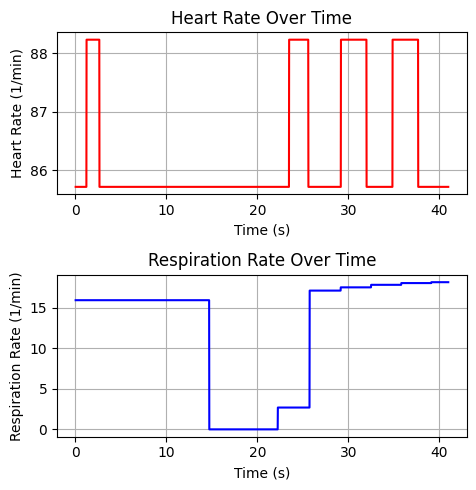

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

csv_file_path = "./simulation_results/UseCase1.csv"
df = pd.read_csv(csv_file_path)
fig, axs = plt.subplots(2, 1, figsize=(5, 5))

# Heart Rate plot
axs[0].plot(df['Time(s)'], df['HeartRate(1/min)'], color='red')
axs[0].set_title('Heart Rate Over Time')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Heart Rate (1/min)')
axs[0].grid(True)

# Respiration Rate plot
axs[1].plot(df['Time(s)'], df['RespirationRate(1/min)'], color='blue')
axs[1].set_title('Respiration Rate Over Time')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Respiration Rate (1/min)')
axs[1].grid(True)

plt.tight_layout()
plt.show()
